In [1]:
import numpy as np
import torch
from PIL import Image
from timm.data.transforms_factory import create_transform
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import math
import warnings
warnings.filterwarnings('ignore')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [46]:
from torchvision import transforms

def preprocess_image(image_path, input_size=(120, 120), mean=(0.485, 0.456, 0.406, 0.0), std=(0.229, 0.224, 0.225, 1.0)):
    # Load the image
    image = Image.open(image_path).convert('RGB')
    
    # Define a simple transformation pipeline for resizing and converting to tensor
    transform = transforms.Compose([
        transforms.Resize(input_size),  # Resize the image
        transforms.ToTensor(),  # Convert image to tensor
    ])
    
    # Apply the transformation pipeline
    image_tensor = transform(image)

    # Create an alpha channel filled with ones and the same size as the other channels
    alpha_channel = torch.ones(1, *image_tensor.shape[1:3], dtype=image_tensor.dtype)

    # Concatenate the alpha channel to make the image four-channel
    image_tensor = torch.cat((image_tensor, alpha_channel), dim=0)

    # Normalize the tensor using four-channel mean and std
    normalize = transforms.Normalize(mean=mean, std=std)
    image_tensor = normalize(image_tensor)

    # Add batch dimension
    tensor_image = image_tensor.unsqueeze(0)

    # Use GPU if available
    tensor_image = tensor_image.cuda() if torch.cuda.is_available() else tensor_image
    
    return tensor_image

preprocessed_image = preprocess_image('test2.png')

In [47]:
preprocessed_image.shape

torch.Size([1, 4, 120, 120])

In [3]:
preprocessed_image.shape

torch.Size([1, 4, 120, 120])

In [4]:
''' for 4 tiles 
def cut_into_tiles_tensor(image_tensor, num_tiles=9):

    if num_tiles != 4:
        raise ValueError("This function currently supports only 4 tiles.")
    
    _, C, H, W = image_tensor.shape  
    tile_height, tile_width = H // 3, W // 3
    
    tiles = {
        'tl': image_tensor[:, :, :tile_height, :tile_width],
        'tr': image_tensor[:, :, :tile_height, tile_width:],
        'bl': image_tensor[:, :, tile_height:, :tile_width],
        'br': image_tensor[:, :, tile_height:, tile_width:]
    }
    
    return tiles

tiles = cut_into_tiles_tensor(preprocessed_image, 4)

'''

' for 4 tiles \ndef cut_into_tiles_tensor(image_tensor, num_tiles=9):\n\n    if num_tiles != 4:\n        raise ValueError("This function currently supports only 4 tiles.")\n    \n    _, C, H, W = image_tensor.shape  \n    tile_height, tile_width = H // 3, W // 3\n    \n    tiles = {\n        \'tl\': image_tensor[:, :, :tile_height, :tile_width],\n        \'tr\': image_tensor[:, :, :tile_height, tile_width:],\n        \'bl\': image_tensor[:, :, tile_height:, :tile_width],\n        \'br\': image_tensor[:, :, tile_height:, tile_width:]\n    }\n    \n    return tiles\n\ntiles = cut_into_tiles_tensor(preprocessed_image, 4)\n\n'

In [48]:
def cut_into_tiles_tensor(image_tensor, num_tiles=9):
    if num_tiles != 9:
        raise ValueError("This function currently supports only 9 tiles.")
    
    _, C, H, W = image_tensor.shape
    # Ensure the image dimensions are divisible by 3
    if H % 3 != 0 or W % 3 != 0:
        raise ValueError("Image dimensions must be divisible by 3.")
    
    tile_height, tile_width = H // 3, W // 3
    
    tiles = {
        'tl': image_tensor[:, :, :tile_height, :tile_width],  # Top left
        'tc': image_tensor[:, :, :tile_height, tile_width:2*tile_width],  # Top center
        'tr': image_tensor[:, :, :tile_height, 2*tile_width:],  # Top right
        'ml': image_tensor[:, :, tile_height:2*tile_height, :tile_width],  # Middle left
        'mc': image_tensor[:, :, tile_height:2*tile_height, tile_width:2*tile_width],  # Middle center
        'mr': image_tensor[:, :, tile_height:2*tile_height, 2*tile_width:],  # Middle right
        'bl': image_tensor[:, :, 2*tile_height:, :tile_width],  # Bottom left
        'bc': image_tensor[:, :, 2*tile_height:, tile_width:2*tile_width],  # Bottom center
        'br': image_tensor[:, :, 2*tile_height:, 2*tile_width:]  # Bottom right
    }
    
    return tiles

tiles = cut_into_tiles_tensor(preprocessed_image)


In [49]:
def create_permuted_images_tensor(tiles, num_permutations):
    # Assuming tiles is a dictionary of tensors and we have a square number of them
    num_tiles = len(tiles)
    n = int(math.sqrt(num_tiles))  # n x n grid
    if n ** 2 != num_tiles:
        raise ValueError("Number of tiles must be a perfect square.")

    tile_positions = list(tiles.keys())
    permuted_images = []

    for _ in range(num_permutations):
        random.shuffle(tile_positions)
        rows = []

        for i in range(0, num_tiles, n):
            # Concatenate tiles along width to form one row
            row = torch.cat([tiles[pos] for pos in tile_positions[i:i+n]], dim=3)
            rows.append(row)

        # Concatenate all rows along height to form the new image
        new_img_tensor = torch.cat(rows, dim=2)
        permuted_images.append(new_img_tensor)

    return torch.stack(permuted_images)

permuted_images_tensors = create_permuted_images_tensor(tiles, 1)

In [23]:
permuted_images_tensors.shape

torch.Size([1, 1, 4, 120, 120])

In [29]:

from vig import Grapher

num_patches = 9

grapher_module = Grapher(
    in_channels=4,         # RGB image has 3 channels
    kernel_size=3,         # A common choice, could be different based on your architecture
    dilation=1,            # Standard dilation
    conv='edge',           # Replace 'edge' with the actual type used in your model
    act='relu',            # A common activation function
    norm=None,             # Depends on whether you want to use normalization
    bias=True,             # Typically, biases are used
    stochastic=False,      # If stochastic depth is not used
    epsilon=0.0,           # Hyperparameter for the edge convolution
    r=1,                   # Downsampling rate
    n=num_patches,         # Number of nodes
    drop_path=0.0,         # Drop path rate for stochastic depth
    relative_pos=True,
    # groups = 1     # Set to True if the model uses relative positions
)

grapher_module = grapher_module.to(permuted_images_tensors[0][0].device)
print(grapher_module)

graph_output = grapher_module(permuted_images_tensors[0])



using relative_pos
Grapher(
  (fc1): Sequential(
    (0): Conv2d(4, 4, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (graph_conv): DyGraphConv2d(
    (gconv): EdgeConv2d(
      (nn): BasicConv(
        (0): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1), groups=4)
        (1): ReLU()
      )
    )
    (dilated_knn_graph): DenseDilatedKnnGraph(
      (_dilated): DenseDilated()
    )
  )
  (fc2): Sequential(
    (0): Conv2d(8, 4, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (drop_path): Identity()
)
hi
tensor([[[[  468,   240,     0],
          [  241,   396,   342],
          [  221,   320,   317],
          ...,
          [14102, 14038, 14037],
          [14103, 14159, 14037],
          [14158, 14114, 14222]]],


        [[[    0,     0,     0],
          [    1,     1,     1],
          [    2,     2,     2],
          .

In [30]:
print(graph_output.shape)

torch.Size([1, 4, 120, 120])


In [31]:
print(graph_output)

tensor([[[[-0.8643, -0.9693, -2.7549,  ...,  1.1750,  1.1317,  0.4269],
          [-1.3121, -2.4954, -1.6728,  ...,  0.1958,  0.8510,  1.4509],
          [-0.5851, -0.9483, -2.7725,  ..., -0.0892,  0.9190, -0.6352],
          ...,
          [ 0.0938,  0.4703,  0.5719,  ...,  1.9755,  1.5704,  1.6512],
          [ 0.2379,  0.4703,  0.5719,  ...,  1.1840,  0.8719,  0.5721],
          [ 0.1268,  0.3788,  0.3472,  ...,  1.3918,  1.4694,  0.9711]],

         [[-0.8979, -1.3225, -1.7343,  ...,  1.3417,  1.3368,  1.8648],
          [-1.2452, -3.1373, -1.7768,  ...,  2.6332,  1.3076,  0.6764],
          [-0.8848, -1.4061, -2.4146,  ...,  2.9696,  2.1871,  3.1120],
          ...,
          [-0.6018, -0.4366, -0.3678,  ...,  0.9316,  0.8237,  0.9520],
          [-0.5348, -0.4366, -0.3678,  ...,  1.4208,  1.6809,  1.8741],
          [-0.4107, -0.3886, -0.4371,  ..., -0.5538, -0.4254,  1.2252]],

         [[-0.7564, -0.3978, -0.8592,  ..., -0.7951, -0.6363, -1.1126],
          [-0.7727, -0.4628, -

In [12]:
preprocessed_image.shape

torch.Size([1, 4, 120, 120])

In [32]:

pool = nn.AdaptiveAvgPool2d((3, 3))

pooled_output = pool(graph_output)

print(pooled_output.shape) 

torch.Size([1, 4, 3, 3])


In [33]:
from gcn_lib import DenseDilatedKnnGraph

dense_dilated_knn_graph = DenseDilatedKnnGraph(k=3, dilation=1, stochastic=False, epsilon=0.0)

num_points = pooled_output.shape[2] * pooled_output.shape[3]  # For a 224x224 image, this would be 50176
pooled_output_reshaped = pooled_output.reshape(1, 4, num_points, 1)  # Reshape to [1, 4, 50176, 1]

# Use the module to find edges
edge_index = dense_dilated_knn_graph(pooled_output_reshaped)

# edge_index now contains the indices of edges based on dilated KNN
edge_index.shape

torch.Size([2, 1, 9, 3])

In [34]:
k=3
edge_index_flat = edge_index.view(2, -1)

edge_index_flat.shape

torch.Size([2, 27])

In [35]:
N = edge_index_flat.shape[1] // k  
print(N)
adjacency_matrix = torch.zeros((N, N))


9


In [36]:
for i in range(edge_index_flat.shape[1]):
    source_node = edge_index_flat[0, i]
    target_node = edge_index_flat[1, i]

    adjacency_matrix[source_node, target_node] = 1

edge_list = edge_index_flat.t().tolist()  # Convert to a list of tuples

In [35]:
# [[0, 0],
#  [25, 0],
#  [179, 0],
#  [26, 0],
#  [115, 0],
#  [55, 0],
#  [128, 0],
#  [41, 0],
#  [40, 0],
#  [11, 0],
#  [165, 0],
#  [143, 0],
#  [12, 0],
#  [13, 0],
#  [116, 0],
#  [69, 0],
#  [137, 0],
#  [151, 0],
#  [190, 0],
#  [142, 0],

In [37]:
edge_list

[[0, 0],
 [8, 0],
 [5, 0],
 [1, 1],
 [6, 1],
 [2, 1],
 [2, 2],
 [6, 2],
 [1, 2],
 [3, 3],
 [5, 3],
 [8, 3],
 [4, 4],
 [7, 4],
 [1, 4],
 [5, 5],
 [3, 5],
 [8, 5],
 [6, 6],
 [1, 6],
 [2, 6],
 [7, 7],
 [4, 7],
 [1, 7],
 [8, 8],
 [5, 8],
 [3, 8]]

In [13]:
num_nodes = 14*14
feature_dimension = 4
graph_features = pooled_output.reshape(1, feature_dimension, num_nodes)

graph_features = graph_features.squeeze(0)  # This is now of shape [4, 50176]

node_features = {node: [] for node in range(num_nodes)}  # Dictionary to store features for each node

for target_node, source_node in edge_list:

    node_features[target_node].append(graph_features[:, source_node])

In [14]:
edge_list

[[0, 0],
 [111, 0],
 [138, 0],
 [31, 0],
 [93, 0],
 [107, 0],
 [130, 0],
 [15, 0],
 [123, 0],
 [28, 0],
 [17, 0],
 [62, 0],
 [163, 0],
 [113, 0],
 [99, 0],
 [114, 0],
 [1, 0],
 [75, 0],
 [29, 0],
 [135, 0],
 [1, 1],
 [75, 1],
 [17, 1],
 [62, 1],
 [123, 1],
 [98, 1],
 [102, 1],
 [28, 1],
 [112, 1],
 [163, 1],
 [42, 1],
 [113, 1],
 [149, 1],
 [93, 1],
 [134, 1],
 [143, 1],
 [14, 1],
 [140, 1],
 [129, 1],
 [153, 1],
 [2, 2],
 [60, 2],
 [150, 2],
 [124, 2],
 [142, 2],
 [63, 2],
 [59, 2],
 [171, 2],
 [120, 2],
 [186, 2],
 [106, 2],
 [179, 2],
 [72, 2],
 [155, 2],
 [125, 2],
 [74, 2],
 [168, 2],
 [16, 2],
 [91, 2],
 [154, 2],
 [3, 3],
 [61, 3],
 [131, 3],
 [178, 3],
 [110, 3],
 [153, 3],
 [127, 3],
 [128, 3],
 [100, 3],
 [192, 3],
 [134, 3],
 [30, 3],
 [123, 3],
 [157, 3],
 [88, 3],
 [64, 3],
 [75, 3],
 [165, 3],
 [17, 3],
 [93, 3],
 [4, 4],
 [74, 4],
 [139, 4],
 [18, 4],
 [60, 4],
 [179, 4],
 [125, 4],
 [2, 4],
 [124, 4],
 [150, 4],
 [120, 4],
 [16, 4],
 [142, 4],
 [63, 4],
 [32, 4],
 [59, 

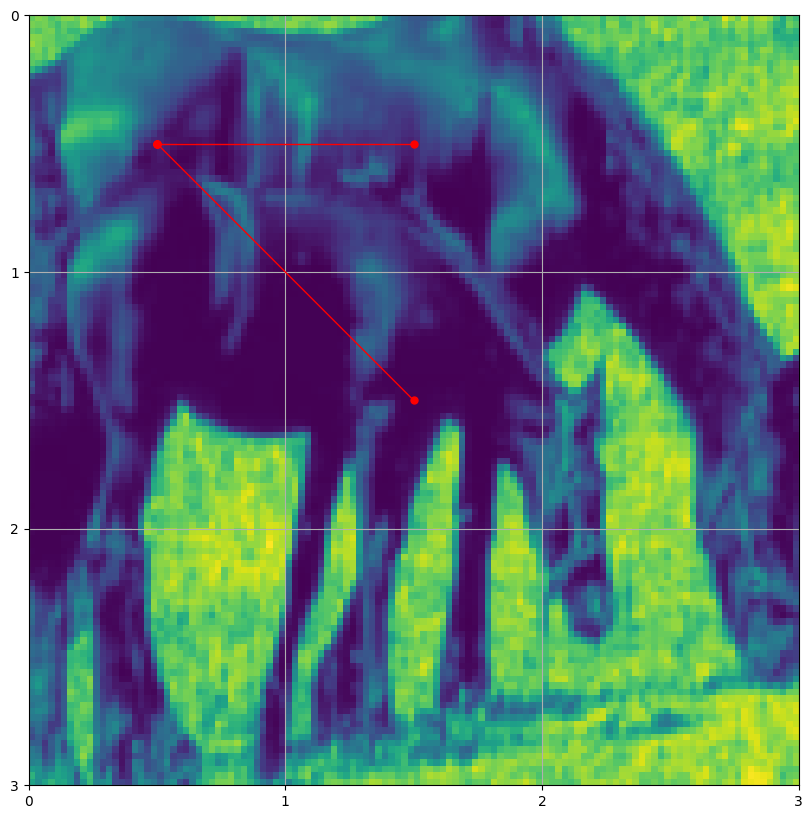

In [21]:


image_array = preprocessed_image[0][0]  # Placeholder for the actual image

grid_size = 4  # Grid size for the 14x14 grid

# Example edge cases
edge_nine = [
[0, 0],
 [1, 0],
 [4, 0]]

# Display the image as a background
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(image_array, extent=[0, grid_size-1, grid_size-1, 0])


ax.set_xlim([0, grid_size-1])
ax.set_ylim([0, grid_size-1])
ax.set_aspect('equal')
# Inverting y-axis to have (0,0) at top-left
ax.set_ylim(ax.get_ylim()[::-1])

ax.set_xticks(np.arange(0, grid_size, 1))
ax.set_yticks(np.arange(0, grid_size, 1))


# Overlay the connections on top of the image
for conn in edge_nine:

    x1, y1 = ((conn[0]) % 3, (conn[0]) // 3)
    x2, y2 = ((conn[1]) % 3, (conn[1]) // 3)

    x1_adjust = x1 + 0.5

    x2_adjust = x2 + 0.5
    
    plt.plot([x1_adjust, x2_adjust], [y1 + 0.5, y2 + 0.5], marker='o', markersize=5, linestyle='-', color='red', linewidth=1)

plt.grid(True)
plt.show()


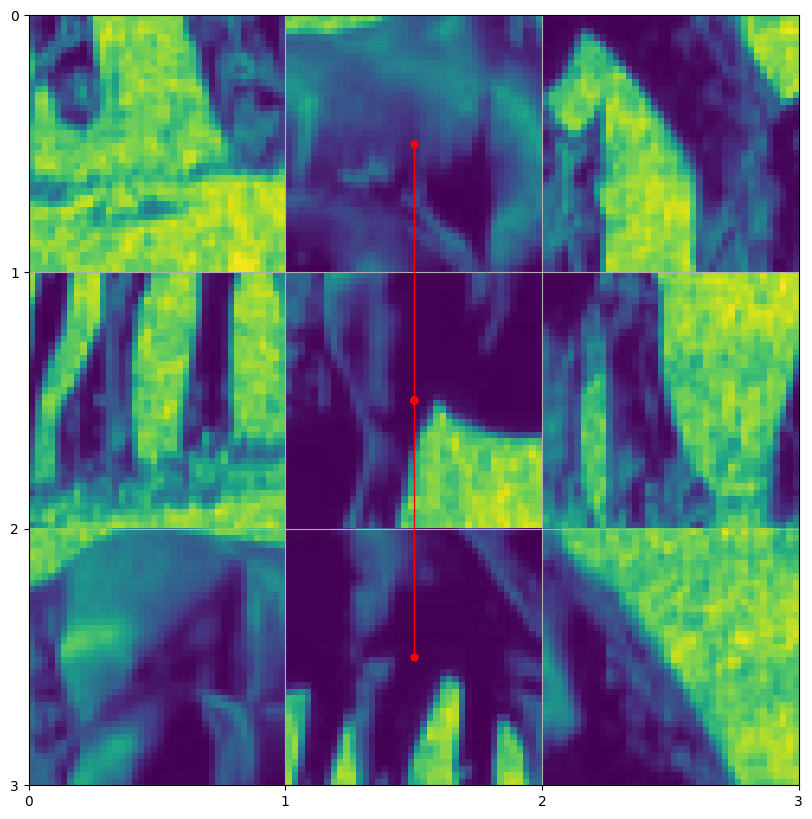

In [40]:


image_array = permuted_images_tensors[0][0][0]  # Placeholder for the actual image

grid_size = 4  # Grid size for the 14x14 grid

# Example edge cases
edge_nine = [
 [4, 4],
 [7, 4],
 [1, 4]]

# Display the image as a background
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(image_array, extent=[0, grid_size-1, grid_size-1, 0])


ax.set_xlim([0, grid_size-1])
ax.set_ylim([0, grid_size-1])
ax.set_aspect('equal')
# Inverting y-axis to have (0,0) at top-left
ax.set_ylim(ax.get_ylim()[::-1])

ax.set_xticks(np.arange(0, grid_size, 1))
ax.set_yticks(np.arange(0, grid_size, 1))


# Overlay the connections on top of the image
for conn in edge_nine:

    x1, y1 = ((conn[0]) % 3, (conn[0]) // 3)
    x2, y2 = ((conn[1]) % 3, (conn[1]) // 3)

    x1_adjust = x1 + 0.5

    x2_adjust = x2 + 0.5
    
    plt.plot([x1_adjust, x2_adjust], [y1 + 0.5, y2 + 0.5], marker='o', markersize=5, linestyle='-', color='red', linewidth=1)

plt.grid(True)
plt.show()
